## Content of Table
<a id='contents'></a>
- [Gather](#Gather)
- [Assess](#Assess)
- [Cleaning](#Cleaning)
- [Insight](#Insight)


### Gathering Data for this Project
<a id='Gather'></a>
Gather each of the three pieces of data as described below in a Jupyter Notebook titled **wrangle_act.ipynb**:

#### The WeRateDogs Twitter archive. 
I am giving this file to you, so imagine it as a file on hand. 
Download this file manually by clicking the following link: twitter_archive_enhanced.csv

#### The tweet image predictions, i.e., 
what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. 
This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
# Read in csv file as a Pandas DataFrame
df_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
#Check missing value
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
#Check stocastics
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [5]:
#Get tsv file from url then save. 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url, auth=('user', 'pass'))
open('image_predictions.tsv', 'wb').write(r.content)

# Read in tsv file as a Pandas DataFrame    
df_image = pd.read_csv('image_predictions.tsv', sep='\t')

In [6]:
#Check missing value
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [7]:
#Check stocastics
df_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


### Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. 
Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

In [4]:
# To use tweeter API, setup session 
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth_handler=auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [4]:
# Loop to add each available tweet to tweet_json.txt
with open('tweet_json.txt', 'a', encoding='utf8') as f:
    for tweet_id in df_archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, f)
            f.write('\n')
        except:
            continue

In [8]:
# Loop to append each tweet into a list
tweets_data = []
tweet_file = open('tweet_json.txt', "r")

for line in tweet_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
        
tweet_file.close()

In [9]:
# Create tweet_info DataFrame
df_json = pd.DataFrame()

In [10]:
#Check header. 
#Then read this .txt file line by line into a pandas DataFrame 
#with (at minimum) tweet ID, retweet count, and favorite count. 
tweets_data[0]

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'large': {'w': 

In [11]:
# Add selected variables to tweet_info DataFrame
df_json['id'] = list(map(lambda tweet: tweet['id'], tweets_data))
df_json['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets_data))
df_json['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets_data))

In [12]:
#Check missing value
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6156 entries, 0 to 6155
Data columns (total 3 columns):
id                6156 non-null int64
retweet_count     6156 non-null int64
favorite_count    6156 non-null int64
dtypes: int64(3)
memory usage: 144.4 KB


In [13]:
#Check stocastics
df_json.describe()

,id,retweet_count,favorite_count
count,6.156000e+03,6156.000000,6156.000000
mean,7.926421e+17,3825.965075,11393.527778
std,6.476222e+16,4938.342417,13635.469603
min,6.660209e+17,1.000000,0.000000
25%,7.605392e+17,1159.750000,1979.500000
50%,8.021858e+17,2499.000000,7828.000000
75%,8.413202e+17,4593.000000,16012.250000
max,8.924206e+17,74296.000000,150564.000000


**Reference: map**<br>
https://stackoverflow.com/questions/43551835/python-pandas-map<br>
https://stackoverflow.com/questions/1303347/getting-a-map-to-return-a-list-in-python-3-x<br>

### Assessing Data for this Project
<a id='Assess'></a>

After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. 
Detect and document at least **eight (8) quality issues and two (2) tidiness issues** in your wrangle_act.ipynb Jupyter Notebook. 
To meet specifications, the issues that satisfy the Project Motivation (see the Key Points header on the previous page) must be assessed.

**link is available for each assessment**
#### Quality
- [df_archive](#RC1)
- [df_image](#RC2)
- [df_json](#RC3)
<br>

- [contents](#contents)

#### Quality
##### `df_archive` table Overview  from data asses <a id='RC1'></a>
1. Column with Null value <br>
> - (Part1)<br>
> in_reply_to_status_id         78 non-null float64<br>
> in_reply_to_user_id           78 non-null float64<br>
> - (Part2)<br>
> retweeted_status_id           181 non-null float64<br>
> retweeted_status_user_id      181 non-null float64<br>
> retweeted_status_timestamp    181 non-null object<br>

2. Float datatype for ID  
> - (Part1)<br>
> in_reply_to_status_id         78 non-null float64<br>
> in_reply_to_user_id           78 non-null float64<br>
> - (Part2)<br>
> retweeted_status_id           181 non-null float64<br>
> retweeted_status_user_id      181 non-null float64<br>
> retweeted_status_timestamp    181 non-null object<br>

3. Text column <br>
> - Contains "amp;" in text column<br>

4. expanded_urls<br>
> - Duplicated twitter

5. Name column <br>
> - dog name is not correct from "a", "the", etc.
> - Missing value seems to be "None"

6. rating_numerator
> - Including outlier from stocastic data and plot

7. rating_denominator
> - Including outlier from stocastic data and plot

#### Tidiness
1. Separate columns for categories (doggo,floofer,pupper,puppo)

In [8]:
#Visual assessment in top 5 row
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [9]:
#Visual assessment in last 5 row
df_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [10]:
# Check stocastic value
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
#dog stage assessment for doggo
df_archive.groupby("doggo").count().head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,floofer,pupper,puppo
doggo,,,,,,,,,,,,,,,,
None,2259,74,74,2259,2259,2259,171,171,171,2203,2259,2259,2259,2259,2259,2259
doggo,97,4,4,97,97,97,10,10,10,94,97,97,97,97,97,97


In [12]:
#dog stage assessment for floofer
df_archive.groupby("floofer").count().head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,pupper,puppo
floofer,,,,,,,,,,,,,,,,
None,2346,78,78,2346,2346,2346,181,181,181,2287,2346,2346,2346,2346,2346,2346
floofer,10,0,0,10,10,10,0,0,0,10,10,10,10,10,10,10


In [15]:
#dog stage assessment for pupper
df_archive.groupby("pupper").count().head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,puppo
pupper,,,,,,,,,,,,,,,,
None,2099,74,74,2099,2099,2099,158,158,158,2042,2099,2099,2099,2099,2099,2099
pupper,257,4,4,257,257,257,23,23,23,255,257,257,257,257,257,257


In [16]:
#dog stage assessment for puppo
df_archive.groupby("puppo").count().head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper
puppo,,,,,,,,,,,,,,,,
None,2326,77,77,2326,2326,2326,176,176,176,2268,2326,2326,2326,2326,2326,2326
puppo,30,1,1,30,30,30,5,5,5,29,30,30,30,30,30,30


**Question:Are there any missing value in df_archive?**

In [9]:
# Missing data assessment
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

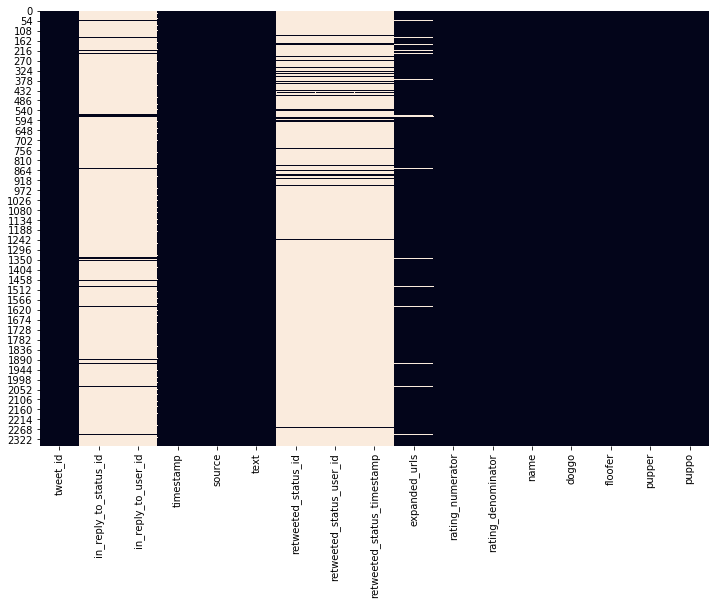

In [10]:
# Heatmap for null value
plt.figure(figsize=(12,8))
sns.heatmap(df_archive.isnull(), cbar=False);

**Question:Are there any no image in expanded_urls ?**

In [48]:
#Assess duplicate volume for expanded_urls column
temp = df_archive[df_archive['expanded_urls'].isnull()]
temp.count()

tweet_id                      59
in_reply_to_status_id         55
in_reply_to_user_id           55
timestamp                     59
source                        59
text                          59
retweeted_status_id            1
retweeted_status_user_id       1
retweeted_status_timestamp     1
expanded_urls                  0
rating_numerator              59
rating_denominator            59
name                          59
doggo                         59
floofer                       59
pupper                        59
puppo                         59
dtype: int64

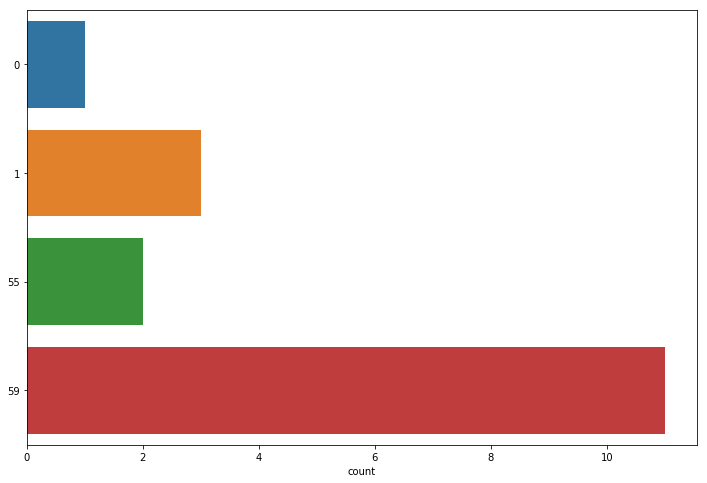

In [49]:
# barplot of duplicate volume
plt.figure(figsize=(12,8))
sns.countplot(data=temp,y=temp.count());

**Quetion:What is the name of the dog with the highest number?**

In [52]:
#Count name in descending order
temp = df_archive.name.value_counts().sort_values(ascending =False).head(10)
temp

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
Cooper      11
Lola        10
Penny       10
Tucker      10
Winston      9
Name: name, dtype: int64

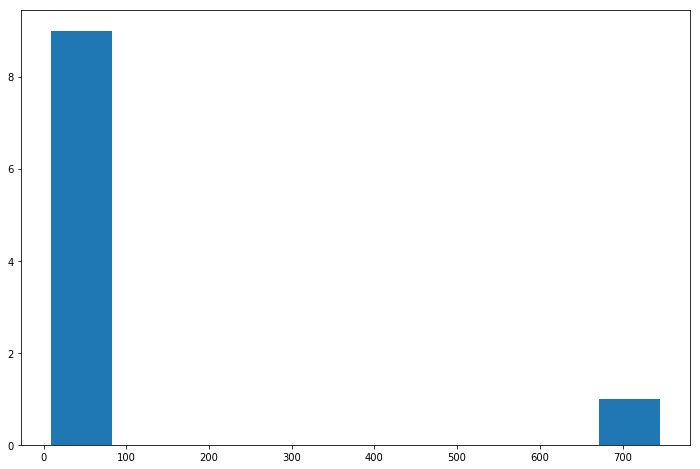

In [63]:
# barplot of name volume
plt.figure(figsize=(12,8))
plt.hist(temp);

To assess name, need more information of another table.

In [64]:
none = df_archive['name'] == 'None'
df_archive[none].head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None


In [15]:
the = df_archive['name'] == 'the'
df_archive[the].head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1527,690360449368465409,NaN,NaN,2016-01-22 02:28:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Stop sending in lobsters. This is the final wa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/690360449...,9,10,the,None,None,None,None
1603,685943807276412928,NaN,NaN,2016-01-09 21:58:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the newly formed pupper a capella grou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685943807...,8,10,the,None,None,pupper,None
1797,677269281705472000,NaN,NaN,2015-12-16 23:29:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the happiest pupper I've ever seen. 10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677269281...,10,10,the,None,None,pupper,None
1815,676613908052996102,NaN,NaN,2015-12-15 04:05:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the saddest/sweetest/best picture I've...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676613908...,12,10,the,None,None,None,None
2037,671561002136281088,NaN,NaN,2015-12-01 05:26:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the best thing I've ever seen so sprea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671561002...,13,10,the,None,None,None,None


**Question:Are there any meaningless character such as amp; ?**

In [65]:
#contains 'amp;' in text column
temp = df_archive[df_archive.text.str.contains('&amp;')]
temp

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
262,842765311967449089,NaN,NaN,2017-03-17 15:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Indie. She's not a fan of baths but she's...,NaN,NaN,NaN,"https://www.gofundme.com/get-indie-home/,https...",12,10,Indie,None,None,None,None
273,840728873075638272,NaN,NaN,2017-03-12 00:59:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Pipsy. He is a fluffbal...,6.671522e+17,4.196984e+09,2015-11-19 01:27:25 +0000,https://twitter.com/dog_rates/status/667152164...,12,10,Pipsy,None,None,None,None
320,834458053273591808,NaN,NaN,2017-02-22 17:41:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Chester (bottom) &amp; Harold (top). They...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/834458053...,12,10,Chester,None,None,None,None
461,817536400337801217,NaN,NaN,2017-01-07 01:00:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Eugene &amp; Patti Melt. No matte...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/817536400...,12,10,Eugene,None,None,None,None
485,814578408554463233,NaN,NaN,2016-12-29 21:06:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur ...,6.981954e+17,4.196984e+09,2016-02-12 17:22:12 +0000,https://twitter.com/dog_rates/status/698195409...,9,10,Beau,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
799,772826264096874500,NaN,NaN,2016-09-05 15:58:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Roosevelt. He's preparing for takeoff. Ma...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772826264...,11,10,Roosevelt,None,None,None,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,doggo,None,pupper,None
898,758854675097526272,NaN,NaN,2016-07-29 02:40:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lilli Bee &amp; Honey Bear. Unfortunat...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758854675...,11,10,Lilli,None,None,None,None
976,750026558547456000,NaN,NaN,2016-07-04 18:00:41 +0000,"<a href=""https://about.twitter.com/products/tw...",Meet Jax &amp; Jil. Jil is yelling the pledge ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750026558...,10,10,Jax,None,None,None,None


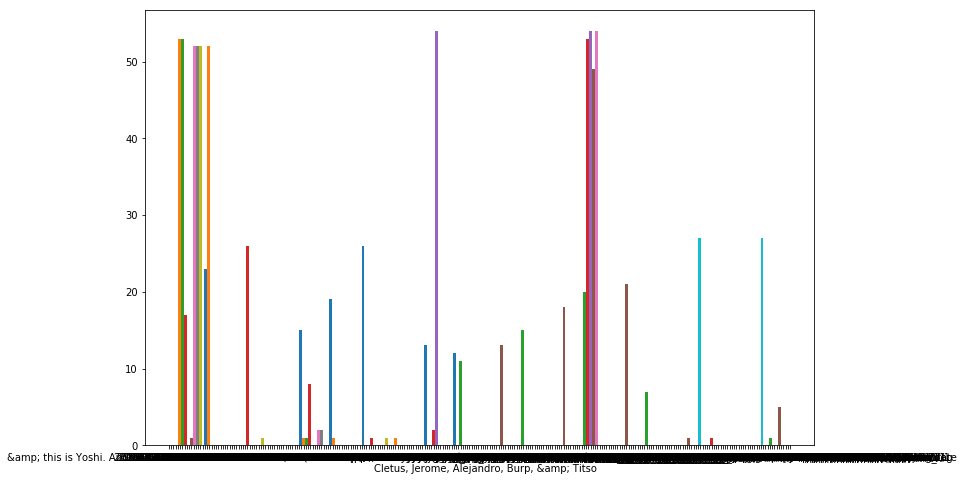

In [66]:
# barplot of 'amp;' in text column  volume
plt.figure(figsize=(12,8))
plt.hist(temp);

**What is "&""amp;"**
> & is HTML for "Start of a character reference".<br>
> "&""amp;" is the character reference for "An ampersand".<br>
**Reference**
https://stackoverflow.com/questions/9084237/what-is-amp-used-for

**Question：Are there any outliers in rating_numerator ?**

In [18]:
# Focus on rating_numerator
df_archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

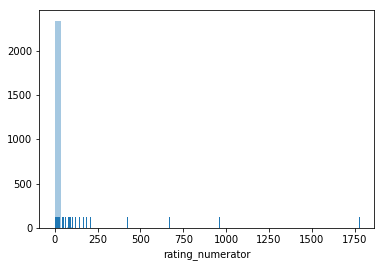

In [19]:
# Show data distribution(Max value seems to be outlier)
sns.distplot(df_archive['rating_numerator'], kde=False, rug=True)

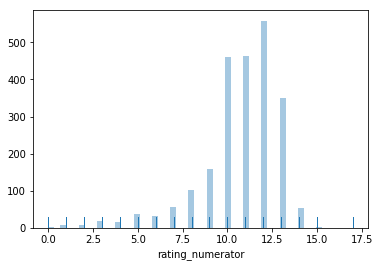

In [18]:
#Histogram of the areas where the frequency is concentrated
x = df_archive[df_archive['rating_numerator'] < 20].rating_numerator
sns.distplot(x, kde=False, rug=True)

**Question：Are there any outliers in rating_denominator ?**

In [20]:
# Focus on rating_numerator
df_archive.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

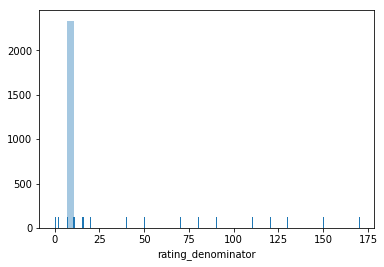

In [10]:
# Show data distribution(Max value seems to be outlier)
sns.distplot(df_archive['rating_denominator'], kde=False, rug=True)

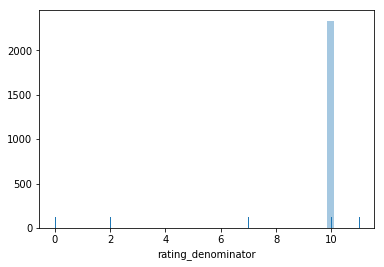

In [21]:
#Histogram of the areas where the frequency is concentrated
x = df_archive[df_archive['rating_denominator']<15].rating_denominator
sns.distplot(x, kde=False, rug=True)

#### Quality
##### `df_image` table <a id='RC2'></a>
1. Duplicated jpg_url.
2. In p1,p2,p3, unnecessary character strings are included in the character information (e.g. - _) 

Reference: jpg_url column contain url but predict performance is not enough.<br>
example: This category is not dog but it is big dog with girl.<br>
https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg
<br>

- [contents](#contents)

In [68]:
#Visual assessment in first 5 row
df_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [69]:
#Visual assessment in last 5 row
df_image.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [130]:
# Missing data assessment for image prediction
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


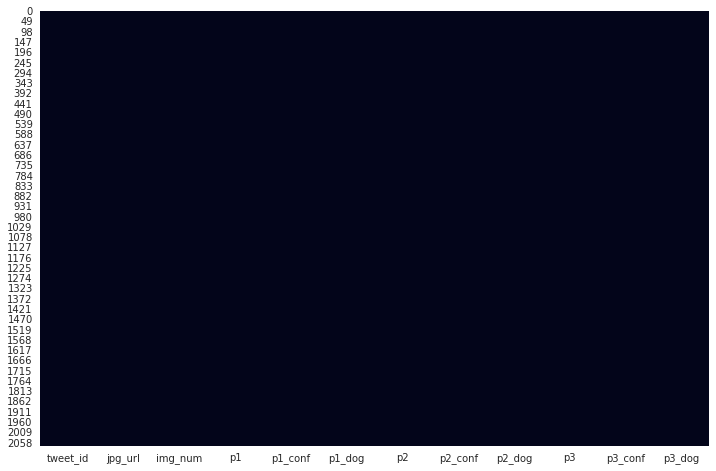

In [131]:
# Heatmap for null value
plt.figure(figsize=(12,8))
sns.heatmap(df_image.isnull(), cbar=False);

In [132]:
# Check stocastic value
df_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


**Question:Are there any duplicate photo url's?**

In [73]:
#Assess duplicate volume for jpg_urls column
temp = df_image[df_image[['jpg_url']].duplicated()].count()
temp

tweet_id    66
jpg_url     66
img_num     66
p1          66
p1_conf     66
p1_dog      66
p2          66
p2_conf     66
p2_dog      66
p3          66
p3_conf     66
p3_dog      66
dtype: int64

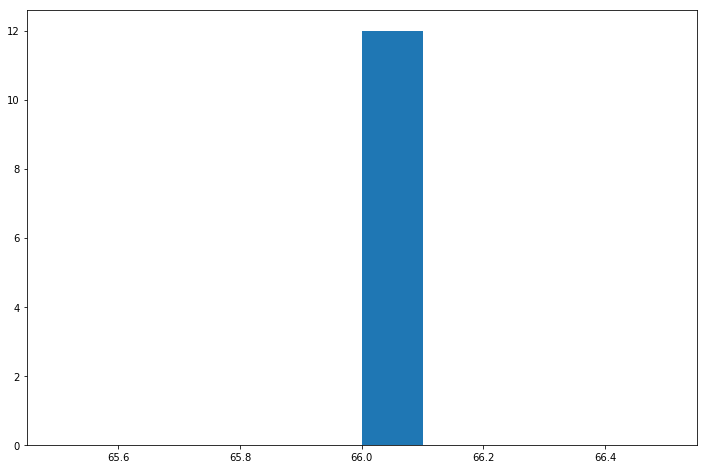

In [75]:
# barplot of jpg_urls  volume
plt.figure(figsize=(12,8))
plt.hist(temp);

**Question:How many photos in the entire table are not classified as dogs?**

In [76]:
# Total volume of image data
len(df_image)

2075

In [77]:
#Total volume of image data without image completely
len(df_image[(df_image['p1_dog']== False) & (df_image['p2_dog'] == False) & (df_image['p3_dog'] == False)])

324

In [78]:
#Check image in first 5 row
temp_df = df_image[(df_image['p1_dog']== False) | (df_image['p2_dog'] == False) | (df_image['p3_dog'] == False)]
temp_df.jpg_url.head()

6     https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg
7     https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg
8     https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg
17    https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg
18    https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg
Name: jpg_url, dtype: object

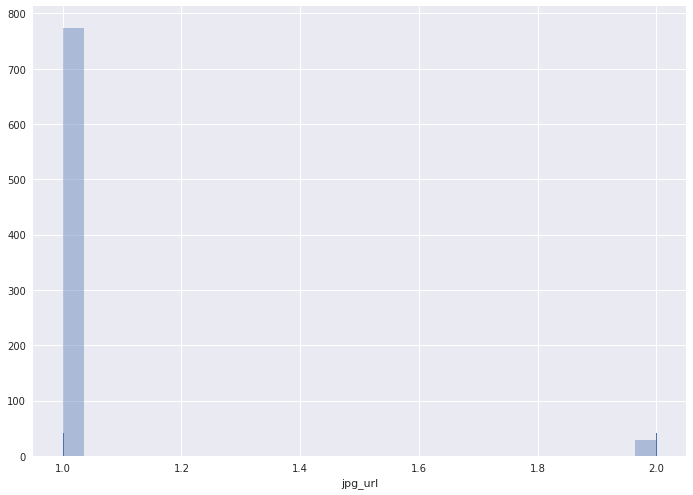

In [150]:
x=temp_df.groupby("jpg_url").jpg_url.count()
sns.distplot(x, kde=False, rug=True)

**Question:Is the predicted type of dog correct?**

p1 group column name: p1, p1_conf, p1_dog

In [79]:
x = df_image.p1.value_counts()
x[:10]

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
chow                   44
Samoyed                43
toy_poodle             39
Pomeranian             38
cocker_spaniel         30
Name: p1, dtype: int64

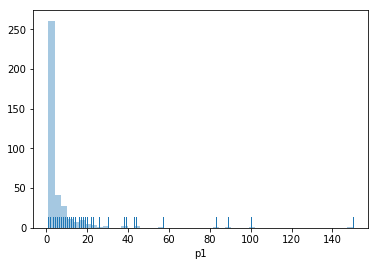

In [80]:
sns.distplot(x, kde=False, rug=True)

In [81]:
x = df_image.p2.value_counts()
x[:10]

Labrador_retriever          104
golden_retriever             92
Cardigan                     73
Chihuahua                    44
Pomeranian                   42
Chesapeake_Bay_retriever     41
French_bulldog               41
toy_poodle                   37
cocker_spaniel               34
Siberian_husky               33
Name: p2, dtype: int64

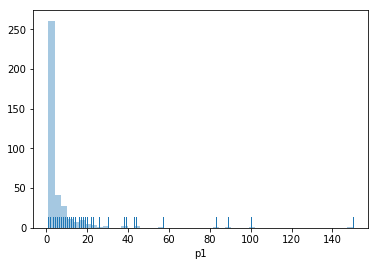

In [32]:
sns.distplot(x, kde=False, rug=True)

In [82]:
x = df_image.p3.value_counts()
x[:10]

Labrador_retriever           79
Chihuahua                    58
golden_retriever             48
Eskimo_dog                   38
kelpie                       35
kuvasz                       34
chow                         32
Staffordshire_bullterrier    32
cocker_spaniel               31
beagle                       31
Name: p3, dtype: int64

#### Overview
##### `df_json` table <a id='RC3'></a>

In [50]:
df_json.head()

,,,,"{""created_at"": ""Tue Aug 01 16:23:56 +0000 2017""","""id"": 892420643555336193","""id_str"": ""892420643555336193""","""full_text"": ""This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU""","""truncated"": false","""display_text_range"": [0",85],"""entities"": {""hashtags"": []","""symbols"": []","""user_mentions"": []",...,"""place"": null","""contributors"": null","""is_quote_status"": false","""retweet_count"": 7355","""favorite_count"": 35023","""favorited"": false","""retweeted"": false","""possibly_sensitive"": false","""possibly_sensitive_appealable"": false","""lang"": ""en""}"
"{""created_at"": ""Tue Aug 01 00:17:27 +0000 2017""","""id"": 892177421306343426","""id_str"": ""892177421306343426""","""full_text"": ""This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not",she's available for pats,snugs,boops,"the whole bit. 13/10 https://t.co/0Xxu71qeIV""","""truncated"": false","""display_text_range"": [0",138],"""entities"": {""hashtags"": []","""symbols"": []","""user_mentions"": []",...,"""place"": null","""contributors"": null","""is_quote_status"": false","""retweet_count"": 5486","""favorite_count"": 30333","""favorited"": false","""retweeted"": false","""possibly_sensitive"": false","""possibly_sensitive_appealable"": false","""lang"": ""en""}"
"{""created_at"": ""Mon Jul 31 00:18:03 +0000 2017""","""id"": 891815181378084864","""id_str"": ""891815181378084864""","""full_text"": ""This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB""","""truncated"": false","""display_text_range"": [0",121],"""entities"": {""hashtags"": []","""symbols"": []","""user_mentions"": []","""urls"": []","""media"": [{""id"": 891815175371796480","""id_str"": ""891815175371796480""","""indices"": [122",...,"""favorite_count"": 22802","""favorited"": false","""retweeted"": false","""possibly_sensitive"": false","""possibly_sensitive_appealable"": false","""lang"": ""en""}",NaN,NaN,NaN,NaN
"{""created_at"": ""Sun Jul 30 15:58:51 +0000 2017""","""id"": 891689557279858688","""id_str"": ""891689557279858688""","""full_text"": ""This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ""","""truncated"": false","""display_text_range"": [0",79],"""entities"": {""hashtags"": []","""symbols"": []","""user_mentions"": []","""urls"": []","""media"": [{""id"": 891689552724799489","""id_str"": ""891689552724799489""","""indices"": [80",...,"""favorite_count"": 38299","""favorited"": false","""retweeted"": false","""possibly_sensitive"": false","""possibly_sensitive_appealable"": false","""lang"": ""en""}",NaN,NaN,NaN,NaN
"{""created_at"": ""Sat Jul 29 00:08:17 +0000 2017""","""id"": 891087950875897856","""id_str"": ""891087950875897856""","""full_text"": ""Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh""","""truncated"": false","""display_text_range"": [0",138],"""entities"": {""hashtags"": [{""text"": ""BarkWeek""","""indices"": [129",138]}],"""symbols"": []","""user_mentions"": []","""urls"": []","""media"": [{""id"": 891087942176911360",...,"""is_quote_status"": false","""retweet_count"": 2716","""favorite_count"": 18418","""favorited"": false","""retweeted"": false","""possibly_sensitive"": false","""possibly_sensitive_appealable"": false","""lang"": ""en""}",NaN,NaN
"{""created_at"": ""Fri Jul 28 16:27:12 +0000 2017""","""id"": 890971913173991426","""id_str"": ""890971913173991426""","""full_text"": ""Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl""","""truncated"": false","""display_text_range"": [0",140],"""entities"": {""hashtags"": []","""symbols"": []","""user_mentions"": []","""urls"": [{"

In [84]:
df_json.tail()

,id,retweet_count,favorite_count
6151,666049248165822465,38,93
6152,666044226329800704,122,259
6153,666033412701032449,39,107
6154,666029285002620928,41,118
6155,666020888022790149,443,2344


In [85]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6156 entries, 0 to 6155
Data columns (total 3 columns):
id                6156 non-null int64
retweet_count     6156 non-null int64
favorite_count    6156 non-null int64
dtypes: int64(3)
memory usage: 144.4 KB


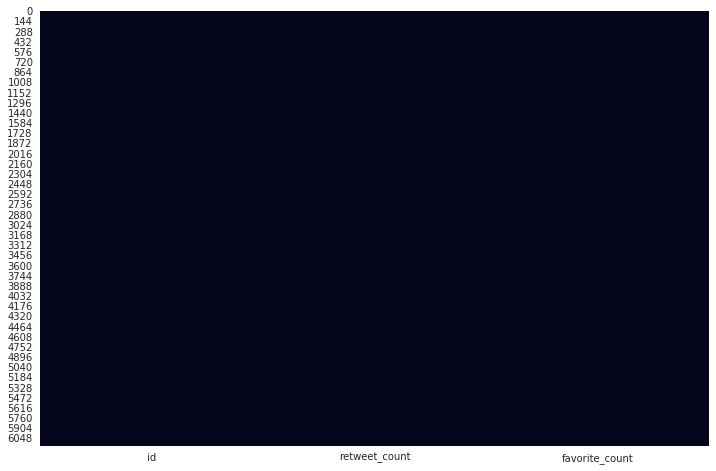

In [134]:
# Heatmap for null value
plt.figure(figsize=(12,8))
sns.heatmap(df_json.isnull(), cbar=False);

In [86]:
df_json.describe()

,id,retweet_count,favorite_count
count,6.156000e+03,6156.000000,6156.000000
mean,7.926421e+17,3825.965075,11393.527778
std,6.476222e+16,4938.342417,13635.469603
min,6.660209e+17,1.000000,0.000000
25%,7.605392e+17,1159.750000,1979.500000
50%,8.021858e+17,2499.000000,7828.000000
75%,8.413202e+17,4593.000000,16012.250000
max,8.924206e+17,74296.000000,150564.000000


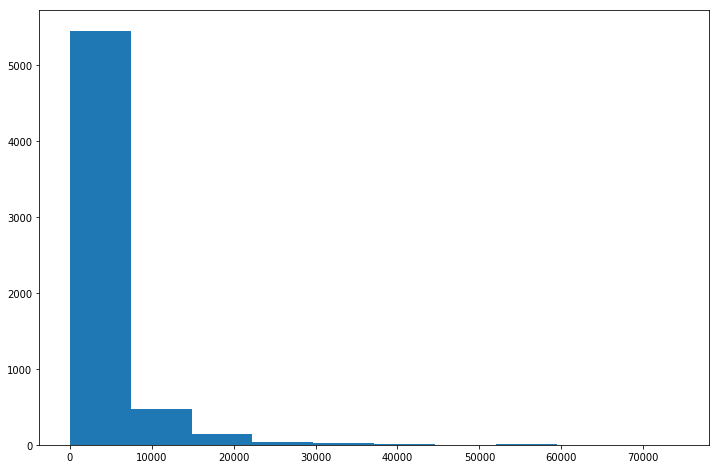

In [93]:
# histgram of retweet_count
temp = df_json.retweet_count
plt.figure(figsize=(12,8))
plt.hist(temp);

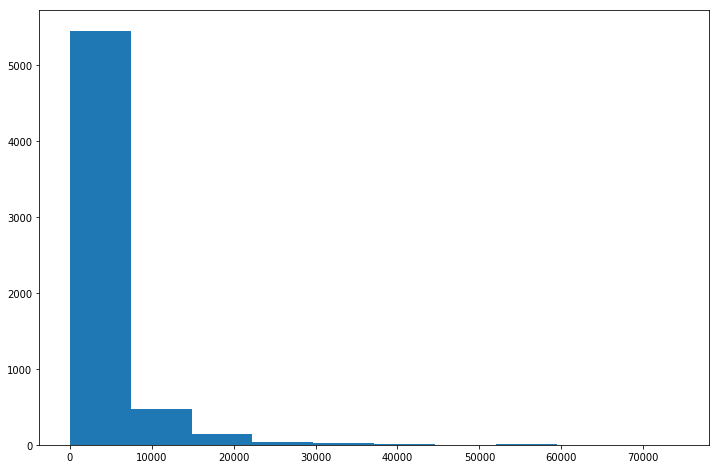

In [92]:
# histgram of favorite_count
temp = df_json.retweet_count
plt.figure(figsize=(12,8))
plt.hist(temp);

**Question:Are there any duplicates in the ID column?**

In [87]:
df_json.id.duplicated().sum()

3825

### Summary of Assess

#### Quality
##### df_archive
1. 5 column with Null value <br>
2. Float datatype is uesd in ID for 5column  <br>
3. Text column  Contains "&""amp;" in text column<br>
4. expanded_urls contains No image<br>
5. Name column dog name is not correct from "a", "the", etc.<br>
6. Name column dog name Missing value seems to be "None"<br>
7. rating_numerator has outlier from stocastic data and plot<br>
8. rating_denominator has outlier from stocastic data and plot<br>

##### df_image
1. Duplicated jpg_url.
2. In p1,p2,p3, unnecessary character strings are included in the character information (e.g. - _) <br>

##### df_json
1. Duplicated ID.

#### Tidiness
##### df_archive
1. Information about a single phenomenon is divided into three tables. 
2. The dog's growth stages are divided into four columns.

### Cleaning Data for this Project
<a id='Cleaning'></a>
- [contents](#contents)

In [94]:
# Copy each table for cleadning
c_df_archive = df_archive.copy()
c_df_image = df_image.copy()
c_df_json = df_json.copy()

**Quality issue for df_archive 1: Dupulicated ID**<br>

**Define:**Delete duplicated row in ID
**Code**: Code is below<br>

In [95]:
c_df_json= c_df_json.drop_duplicates(subset='id')

**Test:**

In [96]:
c_df_json.id.duplicated().sum()

0

**Tidiness issue 1:** Information about a single phenomenon is divided into three tables.  <br>

**Define:**Merge the tables using the same information as keys in the three tables.<br>
**Code**: Code is below<br>

In [97]:
c_df_json = c_df_json.rename(columns={'id': 'tweet_id'})
master_df = c_df_archive.merge(c_df_image,on = 'tweet_id')
master_df = master_df.merge(c_df_json, on = 'tweet_id')


**Test**:

In [98]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 30 columns):
tweet_id                      2059 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2059 non-null object
source                        2059 non-null object
text                          2059 non-null object
retweeted_status_id           72 non-null float64
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2059 non-null object
rating_numerator              2059 non-null int64
rating_denominator            2059 non-null int64
name                          2059 non-null object
doggo                         2059 non-null object
floofer                       2059 non-null object
pupper                        2059 non-null object
puppo                         2059 non-null object
jpg_url                       2059 

**Tidiness issue 2**: The dog's growth stages are divided into four columns. 

**Define:**Consolidate four lines of information into one line.<br>
**Code**: Code is below<br>

In [99]:
#Aggregate 4 column to 1 column
master_df['dog_stage'] = master_df["doggo"] + master_df["floofer"] + master_df["pupper"] + master_df["puppo"]

#Change values for categorical quality
master_df['dog_stage'] = master_df['dog_stage'].str.replace('None', '')
master_df['dog_stage'] = master_df['dog_stage'].str.replace('doggopupper', 'doggo_pupper')
master_df['dog_stage'] = master_df['dog_stage'].str.replace('doggofloofer', 'doggo_floofer')
master_df['dog_stage'] = master_df['dog_stage'].str.replace('doggopuppo', 'doggo_puppo');

#Drop columns 
master_df = master_df.drop(["doggo","floofer","pupper","puppo"], axis=1)

In [100]:
#replace multiple dog grow stage
master_df['dog_stage'] = master_df['dog_stage'].str.replace('doggo_pupper', '')
master_df['dog_stage'] = master_df['dog_stage'].str.replace('doggo_puppo', '')
master_df['dog_stage'] = master_df['dog_stage'].str.replace('doggo_floofer', '')

**Test**:

In [101]:
master_df['dog_stage'].value_counts()

           1754
pupper      210
doggo        65
puppo        23
floofer       7
Name: dog_stage, dtype: int64

**Quality Issue**:1. 5 column with Null value <br>

**Define**: Remove all columns with missing values:<br>

**Code**:

In [102]:
#Remove missing value
master_df = master_df[master_df['retweeted_status_id'].isnull()]
master_df = master_df[master_df['in_reply_to_status_id'].isnull()]

**Test**:

In [103]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2058
Data columns (total 27 columns):
tweet_id                      1964 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1964 non-null object
source                        1964 non-null object
text                          1964 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1964 non-null object
rating_numerator              1964 non-null int64
rating_denominator            1964 non-null int64
name                          1964 non-null object
jpg_url                       1964 non-null object
img_num                       1964 non-null int64
p1                            1964 non-null object
p1_conf                       1964 non-null float64
p1_dog                        1964 non-n

**Quality Issue 2:** Float datatype is uesd in ID for 5column <br>
**Define:** Drop 5 column having Null value <br>

**Code**:<br>

In [104]:
master_df = master_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp']
, axis=1)

**Test**:

In [105]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 2058
Data columns (total 22 columns):
tweet_id              1964 non-null int64
timestamp             1964 non-null object
source                1964 non-null object
text                  1964 non-null object
expanded_urls         1964 non-null object
rating_numerator      1964 non-null int64
rating_denominator    1964 non-null int64
name                  1964 non-null object
jpg_url               1964 non-null object
img_num               1964 non-null int64
p1                    1964 non-null object
p1_conf               1964 non-null float64
p1_dog                1964 non-null bool
p2                    1964 non-null object
p2_conf               1964 non-null float64
p2_dog                1964 non-null bool
p3                    1964 non-null object
p3_conf               1964 non-null float64
p3_dog                1964 non-null bool
retweet_count         1964 non-null int64
favorite_count        1964 non-null int64

**Quality Issue 3: text column Contains "&""amp;" in text column**<br>

**Define**: Delete & amp; from text column."<br>
**Code**:

In [106]:
master_df['text'] = master_df['text'].str.replace('&amp;', '')

**Test**:

In [107]:
master_df[master_df.text.str.contains('&amp;')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,dog_stage


**Quality Issue 4: expanded_urls contains No image**<br>

**Define:** Extract only columns that contain unique url<br>
**Code**:<br>

In [108]:
master_df.dropna(subset=['expanded_urls']);

**Test**:    

In [109]:
master_df['expanded_urls'].isnull().sum()

0

**Quality Issue 5:**Name column dog name is not correct from "a", "the", etc.<br>

**Define:** Replace incorrect dog name to NaN<br>
**Code**:<br>

In [110]:
#Start lower case means incorect then replace NaN
master_df['name'] = master_df['name'].replace('^[a-z]', np.NaN, regex=True)

**Test**:<br>

In [111]:
master_df['name'].value_counts().head()

None       524
Oliver      10
Cooper      10
Charlie     10
Penny        9
Name: name, dtype: int64

**Quality Issue 6: Name column dog name Missing value seems to be "None**<br>

**Define:**Replace the word None with NaN<br>
**Code**:<br>

In [112]:
master_df['name'] = master_df['name'].replace('None',np.NaN)

**Test**<br>

In [113]:
master_df['name'].str.contains('None').sum()

0

**Quality Issue 7:** Column rating_numerator has outlier<br>

**Define:**Drop lines with more than 10 numbers in rating_numerator column.<br>
**Code**:<br>

In [114]:
target = master_df[master_df['rating_denominator']>10].rating_denominator.index
master_df = master_df.drop(target)

**Test:**

In [115]:
master_df[master_df['rating_denominator']>10].rating_denominator.count()

0

**Quality Issue 8:** Column rating_numerator has outlier<br>

**Define:**Drop lines with more than 10 numbers in rating_numerator column<br>
**Code**:<br>

In [116]:
target = master_df[master_df['rating_numerator']>15].rating_numerator.index
master_df = master_df.drop(target)

**Test:**

In [117]:
master_df[master_df['rating_numerator']>15].rating_numerator

Series([], Name: rating_numerator, dtype: int64)

**Quality Issue 9:** Duplicated jpg_url<br>

**Define:**Drop duplicated jpg_url<br>
**Code**:<br>

In [118]:
master_df.drop_duplicates(subset=['jpg_url']);

**Test:**

In [119]:
master_df.jpg_url.duplicated().sum()

0

**Quality Issue 10:** In p1,p2,p3, unnecessary character strings are included in the character information (e.g. - _) <br>

**Define:**Delete "-" and "_"  from p1,p2,p3 column<br>
**Code**:<br>

In [120]:
master_df[['p1', 'p2', 'p3']] = master_df[['p1', 'p2', 'p3']].replace("_", " ", regex = True)
master_df[['p1', 'p2', 'p3']] = master_df[['p1', 'p2', 'p3']].replace("-", " ", regex = True)

**Test**:

In [121]:
master_df.p1.tail(20).str.contains("-").sum()

0

In [122]:
master_df.p1.tail(20).str.contains("_").sum()

0

### Storing, Analyzing, and Visualizing Data for this Project

Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv. If additional files exist because multiple tables are required for tidiness, name these files appropriately. Additionally, you may store the cleaned data in a SQLite database (which is to be submitted as well if you do).

Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. **At least three (3) insights and one (1) visualization** must be produced.

- [contents](#contents)
<a id='Insight'></a>

In [123]:
master_df.to_csv('twitter_archive_master.csv',index=False)

In [124]:
clean_df = pd.read_csv('twitter_archive_master.csv')

**Question 1:** Can you give me the top 10 dog names?

In [125]:
temp =clean_df.name.value_counts().sort_values(ascending =False).head(10)
temp

Oliver     10
Charlie    10
Cooper     10
Tucker      9
Penny       9
Lucy        9
Sadie       8
Winston     8
Lola        7
Daisy       7
Name: name, dtype: int64

**Question 2:** What are the growth stages of dogs with the highest number of posts?

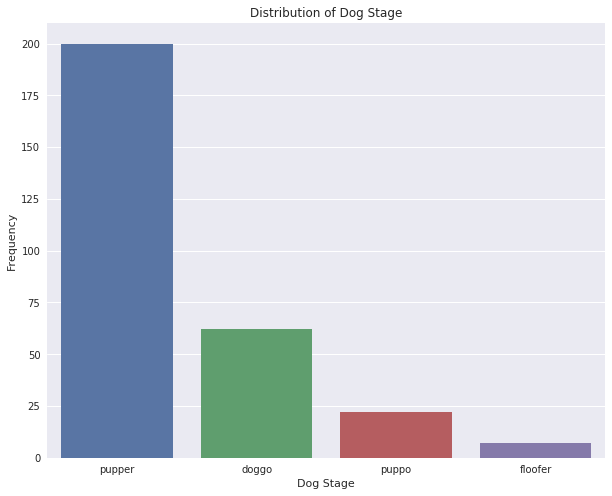

In [126]:
sns.set(rc={'figure.figsize':(10,8)})
x =clean_df.dog_stage.value_counts().index
y =clean_df.dog_stage.value_counts()
g = sns.barplot(x,y)
g.set(xlabel='Dog Stage', ylabel='Frequency',title="Distribution of Dog Stage");
g.legend()

**Question3:** Is there a relationship between the number of reposts and the growth stage of the dog?

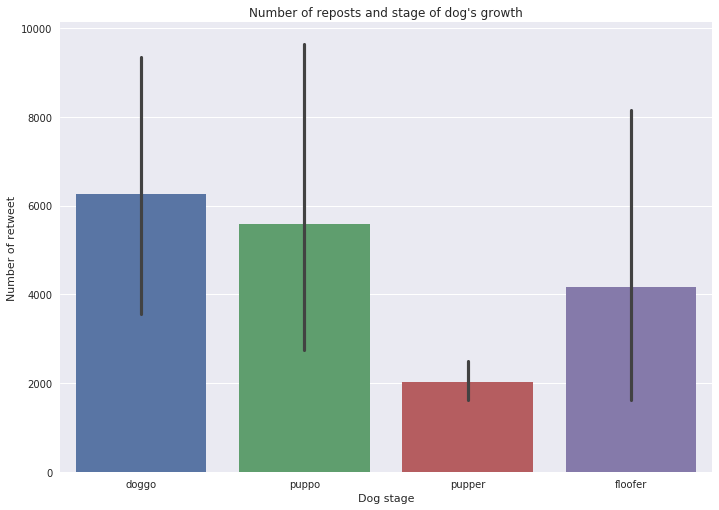

In [127]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
x =clean_df.dog_stage
y =clean_df.retweet_count
g = sns.barplot(x,y)
g.set(xlabel='Dog stage', ylabel='Number of retweet',title="Number of reposts and stage of dog's growth");
g.legend()

**Question4:** Is there a relationship between the number of reposts and the number of favorite?

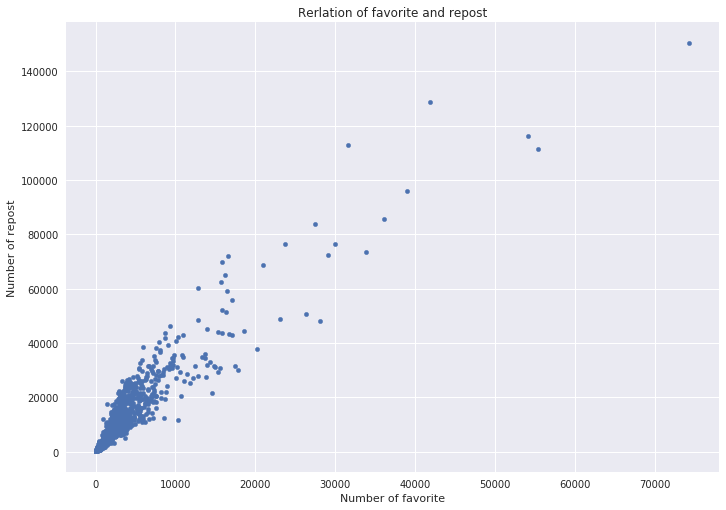

In [128]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
g=clean_df.plot(kind='scatter', x='retweet_count',y='favorite_count');
g.set(xlabel='Number of favorite', ylabel='Number of repost',title="Rerlation of favorite and repost");
g.legend()

In [129]:
#Stocastics
clean_df[["favorite_count","retweet_count"]].describe()

,favorite_count,retweet_count
count,1943.000000,1943.000000
mean,8047.736490,2359.209470
std,11862.364836,4229.407895
min,69.000000,11.000000
25%,1697.000000,526.000000
50%,3621.000000,1138.000000
75%,10047.000000,2701.500000
max,150564.000000,74296.000000
